# GAN(Generative Adversarial Network)
### GAN을 통한 데이터 generate 하는 과정 예시를 보여주기 위한 소스 코드입니다.
- 실제 데이터와 가짜 데이터를 생성하는 모델에서 생성된 데이터를 대립하게 하는 알고리즘인 GAN을 통해 새로운 데이터를 생성한다.
- Noise로부터 데이터를 생성하는 생성 모델이 학습에 사용된 실제 데이터의 분포를 크게 벗어나는 있을 법한 데이터를 생성하는 것이 가능할까?에 대해 확인하기 위해 이 소스코드를 작성하였다.

- reference: https://github.com/hwalsuklee/tensorflow-GAN-1d-gaussian-ex/blob/master/GAN_1d_gaussain_ex.py

In [1]:
import numpy as np
import os
import cv2
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

print('tensorflow ver:', tf.__version__)
print('openCV ver:', cv2.__version__)

/Users/kimsu/py36tf1x/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


tensorflow ver: 1.4.0
openCV ver: 3.4.0


### Data 생성

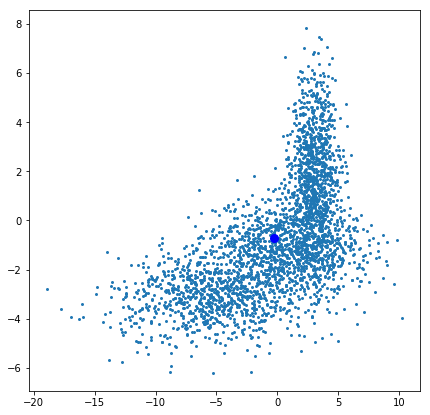

In [2]:
data = np.random.normal(loc=[3, 2], scale=[1, 2], size=[1000,2])
data = np.vstack([data, np.random.normal(loc=[1, -1], scale=[3, 1], size=[1000,2])])
data = np.vstack([data, np.random.normal(loc=[-5, -3], scale=[4, 1], size=[1000,2])])

mu_data = np.mean(data, axis=0)

fig = plt.figure(figsize=(7, 7))
plt.scatter(data[:,0], data[:,1], marker='.', linewidths=0)
plt.scatter(mu_data[0], mu_data[1], marker='o', linewidths=3, c=(0, 0, 1))

### Plotting Function

In [3]:
def scatter_data(x_data, y_data, title="", marker='.', c='b', linewidths=0, figsize=(7, 7)):
    fig = plt.figure(figsize=figsize)
    plt.scatter(x_data, y_data, marker=marker, c=c, linewidths=linewidths)
    plt.title(title, size=15)
    plt.show()

def scatter_2_data(data1, data2, titles=None, marker='.', c1='b', c2='b', linewidths=0, figsize=(15, 7)):
    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.scatter(data1[:, 0], data1[:, 1], marker=marker, c=c1, linewidths=linewidths)
    if titles is not None:
        plt.title(titles[0], size=15)
    
    plt.subplot(1, 2, 2)
    plt.scatter(data2[:, 0], data2[:, 1], marker=marker, c=c2, linewidths=linewidths)
    if titles is not None:
        plt.title(titles[1], size=15)
    plt.show()
    
def scatter_2_data_test_sample(data1, data2, sample1, sample2, titles=None, marker='.', c1='b', c2='b', linewidths=0, figsize=(15, 7)):
    fig = plt.figure(figsize=figsize)
    sample_color = np.random.rand(len(sample1), 3)
    plt.subplot(1, 2, 1)
    plt.scatter(data1[:, 0], data1[:, 1], marker=marker, c=c1, linewidths=linewidths)
    plt.scatter(sample1[:, 0], sample1[:,1], marker='x', c=sample_color, linewidths=10)
    if titles is not None:
        plt.title(titles[0], size=15)
    
    plt.subplot(1, 2, 2)
    plt.scatter(data2[:, 0], data2[:, 1], marker=marker, c=c2, linewidths=linewidths)
    plt.scatter(sample2[:, 0], sample2[:,1], marker='x', c=sample_color, linewidths=10)
    if titles is not None:
        plt.title(titles[1], size=15)
    plt.show()

### GAN

In [14]:
a = np.random.normal(0.0, 1, [3,2])
print(a)
a.sort(axis=0)
print(a)

[[-0.65686833  0.99662278]
 [ 2.17737808  0.02354331]
 [ 0.20777012  0.36060709]]
[[-0.65686833  0.02354331]
 [ 0.20777012  0.36060709]
 [ 2.17737808  0.99662278]]


In [16]:
a = np.random.random([3, 2])
print(a)
print(a * 5)
print(a * 5 / 2)

[[0.97586508 0.10818224]
 [0.05517311 0.33371816]
 [0.6628685  0.96089433]]
[[4.87932538 0.54091122]
 [0.27586553 1.66859082]
 [3.31434248 4.80447166]]
[[2.43966269 0.27045561]
 [0.13793276 0.83429541]
 [1.65717124 2.40223583]]


In [4]:
RANGE = 5

# p_d(x)
class DataDistribution(object):
    def __init__(self, mu, sigma, dim):
        self.mu = mu
        self.sigma = sigma
        self.dim = dim

    def sample(self, N):
        samples = np.random.normal(self.mu, self.sigma, [N, self.dim])
        samples.sort(axis=0)
        return samples


# p_z(z)
class NoiseDistribution(object):
    def __init__(self, range, dim):
        self.range = range
        self.dim = dim

    # equally spaced samples + noise
    def sample(self, N):
        offset = np.random.random(N) * (float(self.range) / N)
        samples = np.linspace(-self.range, self.range, N) + offset
        return samples

In [5]:
# G(z)
def generator(x, n_hidden=32, n_out_dim=2):
    # initializers
    w_init = tf.truncated_normal_initializer(stddev=2)
    b_init = tf.constant_initializer(0.)

    # 1st hidden layer
    w0 = tf.get_variable('w0', [x.get_shape()[1], n_hidden], initializer=w_init)
    b0 = tf.get_variable('b0', [n_hidden], initializer=b_init)
    h0 = tf.nn.relu(tf.matmul(x, w0) + b0)

    # 2nd hidden layer
    w1 = tf.get_variable('w1', [h0.get_shape()[1], n_hidden], initializer=w_init)
    b1 = tf.get_variable('b1', [n_hidden], initializer=b_init)
    h1 = tf.nn.relu(tf.matmul(h0, w1) + b1)
    
    # output layer
    wo = tf.get_variable('wo', [h0.get_shape()[1], n_out_dim], initializer=w_init)
    bo = tf.get_variable('bo', [n_out_dim], initializer=b_init)
    o = tf.matmul(h1, wo) + bo

    return o


# D(x)
def discriminator(x, n_hidden=32):
    # initializers
    w_init = tf.contrib.layers.variance_scaling_initializer()
    b_init = tf.constant_initializer(0.)

    # 1st hidden layer
    w0 = tf.get_variable('w0', [x.get_shape()[1], n_hidden], initializer=w_init)
    b0 = tf.get_variable('b0', [n_hidden], initializer=b_init)
    h0 = tf.nn.relu(tf.matmul(x, w0) + b0)
    
    # 2nd hidden layer
    w1 = tf.get_variable('w1', [h0.get_shape()[1], n_hidden], initializer=w_init)
    b1 = tf.get_variable('b1', [n_hidden], initializer=b_init)
    h1 = tf.nn.relu(tf.matmul(h0, w1) + b1)

    # output layer
    wo = tf.get_variable('wo', [h1.get_shape()[1], 1], initializer=w_init)
    bo = tf.get_variable('bo', [1], initializer=b_init)
    o = tf.sigmoid(tf.matmul(h1, wo) + bo)

    return o


# re-used for optimizing all networks
def optimizer(loss, var_list, num_decay_steps=400, initial_learning_rate=0.03):
    decay = 0.95
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        initial_learning_rate,
        batch,
        num_decay_steps,
        decay,
        staircase=True
    )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss,
        global_step=batch,
        var_list=var_list
    )
    return optimizer

In [6]:
# plot decision boundaries (init, pre-trained, trained) and p_data, p_g
class ResultPlot(object):
    def __init__(self, num_points, num_bins, mu, sigma):
        self.num_points = num_points    # number of data points to be evaluated
        self.num_bins = num_bins        # number of bins to get histogram

        self.mu = mu                    # mu of p_data
        self.sigma = sigma              # sigma of p_data

        self.xs = np.linspace(-RANGE, RANGE, num_points)    # positions of data
        self.bins = np.linspace(-RANGE, RANGE, num_bins)    # positions of bins

    def show_results(self, db_init, db_pre_trained, db_trained, pd, pg, save_img=True):
        db_x = np.linspace(-RANGE, RANGE, len(db_trained))
        p_x = np.linspace(-RANGE, RANGE, len(pd))
        f, ax = plt.subplots(1)
        ax.plot(db_x, db_init, 'g--', linewidth=2, label='db_init')
        ax.plot(db_x, db_pre_trained, 'c--', linewidth=2, label='db_pre_trained')
        ax.plot(db_x, db_trained, 'g-', linewidth=2, label='db_trained')
        ax.set_ylim(0, max(1, np.max(pd) * 1.1))
        ax.set_xlim(max(self.mu - self.sigma * 3, -RANGE * 0.9), min(self.mu + self.sigma * 3, RANGE * 0.9))
        plt.plot(p_x, pd, 'b-', linewidth=2, label='real data')
        plt.plot(p_x, pg, 'r-', linewidth=2, label='generated data')
        plt.title('1D Generative Adversarial Network: ' + '(mu : %3g,' % self.mu + ' sigma : %3g)' % self.sigma)
        plt.xlabel('Data values')
        plt.ylabel('Probability density')
        plt.legend()
        plt.grid(True)

        if save_img:
            plt.savefig('GAN_1d_gaussian' + '_mu_%g' % self.mu + '_sigma_%g' % self.sigma + '.png')

        plt.show()

### Parameters

In [5]:
# p_data
mu = 0
sigma = 1

# training
B = 150                 # batch-size
LR = 3e-3               # learning rate (generator uses half of this)
TRAIN_ITERS = 3000      # number of iterations

# network
n_hidden = 32           # number of hidden layers

### Build Graph

In [ ]:
# networks : pre-trained discriminator
with tf.variable_scope('D_pre'):
    pre_input = tf.placeholder(tf.float32, shape=(None, 1))
    pre_labels = tf.placeholder(tf.float32, shape=(None, 1))
    D_pre = discriminator(pre_input, n_hidden)

# networks : generator
with tf.variable_scope('Gen'):
    z = tf.placeholder(tf.float32, shape=(None, 1))
    G_z = generator(z, n_hidden)

# networks : discriminator
with tf.variable_scope('Disc') as scope:
    x = tf.placeholder(tf.float32, shape=(None, 1))
    D_real = discriminator(x, n_hidden)
    scope.reuse_variables()
    D_fake = discriminator(G_z, n_hidden)

In [ ]:
# loss for each network
eps = 1e-5  # to prevent log(0) case
pre_loss = tf.reduce_mean(tf.square(D_pre - pre_labels))
loss_g = tf.reduce_mean(-tf.log(D_fake + eps))
loss_d = tf.reduce_mean(-tf.log(D_real + eps) - tf.log(1 - D_fake + eps))

# trainable variables for each network
d_pre_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='D_pre')
d_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Disc')
g_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Gen')

# optimizer for each network
pre_opt = optimizer(pre_loss, d_pre_params, 400, LR)
opt_d = optimizer(loss_d, d_params, 400, LR)
opt_g = optimizer(loss_g, g_params, 400, LR / 2)

### Training

In [ ]:
# open session and initialize all variables
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# sources
p_data = DataDistribution(mu, sigma)
p_z = NoiseDistribution(RANGE)

# class for result-plot
plot = ResultPlot(10000, 20, mu, sigma)

# plot : initial decision boundary
db_init = np.zeros((plot.num_points, 1))
for i in range(plot.num_points // B):
    db_init[B * i:B * (i + 1)] = sess.run(D_real, {x: np.reshape(plot.xs[B * i:B * (i + 1)], (B, 1))})


### Pre-Training

In [ ]:
# pre-training discriminator
num_pretrain_steps = 1000
for step in range(num_pretrain_steps):

    print('pre-training :  %d/%d' % (step + 1, num_pretrain_steps))

    # Object of pre-training is to make decision boundary as similar as pdf of data (i.e. p_data)
    # Since p_data is unknown in real situation, we get histogram and estimate pdf
    N = 1000
    d = p_data.sample(N)
    n_bins = 100
    histc, edges = np.histogram(d, bins=n_bins, density=True)

    # Estimated pdf is used as labels after normalization
    max_histc = np.max(histc)
    min_histc = np.min(histc)
    labels = (histc - min_histc) / (max_histc - min_histc)
    d = edges[1:]

    # Execute one training step
    sess.run([pre_loss, pre_opt],
             {pre_input: np.reshape(d, (n_bins, 1)), pre_labels: np.reshape(labels, (n_bins, 1))})
print('pre-training finished!')

# store pre-trained variables
weightsD = sess.run(d_pre_params)

# copy weights from pre-training over to new D network
tf.global_variables_initializer().run()
for i, v in enumerate(d_params):
    sess.run(v.assign(weightsD[i]))

# plot : pre-trained decision boundary
db_pre_trained = np.zeros((plot.num_points, 1))
for i in range(plot.num_points // B):
    db_pre_trained[B * i:B * (i + 1)] = sess.run(D_real, {x: np.reshape(plot.xs[B * i:B * (i + 1)], (B, 1))})

### Main-Training

In [ ]:
# training-loop
for step in range(TRAIN_ITERS):

    np.random.seed(np.random.randint(0, TRAIN_ITERS))

    # update discriminator
    x_ = p_data.sample(B)
    z_ = p_z.sample(B)

    loss_d_, _ = sess.run([loss_d, opt_d], {x: np.reshape(x_, (B, 1)), z: np.reshape(z_, (B, 1))})

    # update generator
    z_ = p_z.sample(B)
    loss_g_, _ = sess.run([loss_g, opt_g], {z: np.reshape(z_, (B, 1))})

    if step % 10 == 0:
        print('[%d/%d]: loss_d : %.3f, loss_g : %.3f' % (step, TRAIN_ITERS, loss_d_, loss_g_))

""" show results """

# plot : trained decision boundary
db_trained = np.zeros((plot.num_points, 1))
for i in range(plot.num_points // B):
    db_trained[B * i:B * (i + 1)] = sess.run(D_real, {x: np.reshape(plot.xs[B * i:B * (i + 1)], (B, 1))})

# plot : pdf of data distribution
d = p_data.sample(plot.num_points)
pd, _ = np.histogram(d, bins=plot.bins, density=True)

# plot : pdf of generated samples
zs = np.linspace(-RANGE, RANGE, plot.num_points)
g = np.zeros((plot.num_points, 1))
for i in range(plot.num_points // B):
    g[B * i:B * (i + 1)] = sess.run(G_z, {z: np.reshape(zs[B * i:B * (i + 1)], (B, 1))})
pg, _ = np.histogram(g, bins=plot.bins, density=True)

# plot results
plot.show_results(db_init, db_pre_trained, db_trained, pd, pg, save_img=True)

sess.close()

### Dataset Dividing

In [7]:
rnd_data = data.copy()
np.random.shuffle(rnd_data)

In [9]:
train_set_ratio = 0.8

n_data = len(rnd_data)
n_train_data = int(n_data * train_set_ratio)

train_data = rnd_data[:n_train_data]
test_data = rnd_data[n_train_data:]

cur_idx = 0

In [10]:
def next_batch(data, idx, batch_size):
    batch = data[idx:idx+batch_size]
    idx = idx + len(batch)
    if len(batch) == 0:
        np.random.shuffle(data)
        batch = data[:batch_size]
        idx = batch_size
    return batch, idx

def add_noise(data, sig=0.01):
    data_hat = data + np.random.normal(scale=sig, size=data.shape)
    return data_hat

### build Graph

In [11]:
dim_data = 2
dim_z = 2
learning_rate = 1e-4

n_hidden=10

In [12]:
# input placeholders
# In denoising-autoencoder, x_hat == x + noise, otherwise x_hat == x
x_hat = tf.placeholder(tf.float32, shape=[None, dim_data], name='input_img')
x = tf.placeholder(tf.float32, shape=[None, dim_data], name='target_img')

# dropout
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# input for PMLR
z_in = tf.placeholder(tf.float32, shape=[None, dim_z], name='latent_variable')

# network architecture
y, z, loss, mse, KL_divergence = autoencoder(x_hat, x, dim_data, dim_z, n_hidden, keep_prob)

# Decoder for Generating new Datas
decoded = decoder(z_in, dim_data, n_hidden)

# optimization
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

### Train

In [13]:
batch_size = 128
n_samples = len(train_data)

# train
total_batch = int(n_samples / batch_size)
min_tot_loss = 1e99

n_epochs = 2000
n_iter = n_epochs * total_batch

logs_step = n_iter // 100
draw_step = n_iter // 20
save_step = n_iter // 10

In [14]:
def get_color(data):
    data_len = len(data)
    diff = data - mu_data
    norm_diff = np.linalg.norm(diff, axis=1)
    ang = np.arccos(diff[:,0] / norm_diff) / np.pi * 90
    normalized_norm_diff = norm_diff / norm_diff.max()
    
    hsv = np.vstack([ang, normalized_norm_diff * 255, np.ones(data_len) * 255])
    hsv = hsv.transpose()
    hsv = hsv.reshape([-1, data_len, 3])
    hsv = hsv.astype(np.uint8)
    
    rgb_color = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb_color

In [15]:
test_rgb_color = get_color(test_data)

test_rgb_color = test_rgb_color.astype(np.float) / 255
test_rgb_color = test_rgb_color.tolist()[0]

Iter 0: L_tot 6071.158 L_MSE 6068.190 L_divergence 2.967


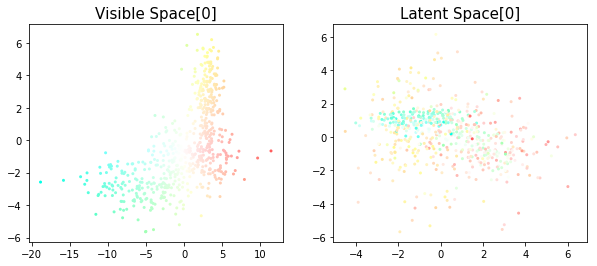

Iter 360: L_tot 2324.494 L_MSE 2321.496 L_divergence 2.998
Iter 720: L_tot 3502.997 L_MSE 3499.661 L_divergence 3.336
Iter 1080: L_tot 2161.134 L_MSE 2157.338 L_divergence 3.795
Iter 1440: L_tot 2322.859 L_MSE 2318.546 L_divergence 4.313
Iter 1800: L_tot 2089.261 L_MSE 2084.690 L_divergence 4.572


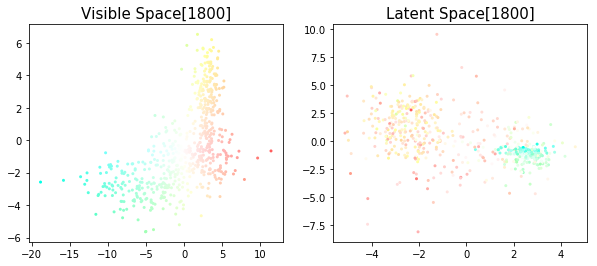

Iter 2160: L_tot 1703.218 L_MSE 1697.975 L_divergence 5.242
Iter 2520: L_tot 1955.057 L_MSE 1949.851 L_divergence 5.205
Iter 2880: L_tot 1776.680 L_MSE 1771.256 L_divergence 5.424
Iter 3240: L_tot 1452.915 L_MSE 1447.187 L_divergence 5.729
Iter 3600: L_tot 1058.293 L_MSE 1052.488 L_divergence 5.805


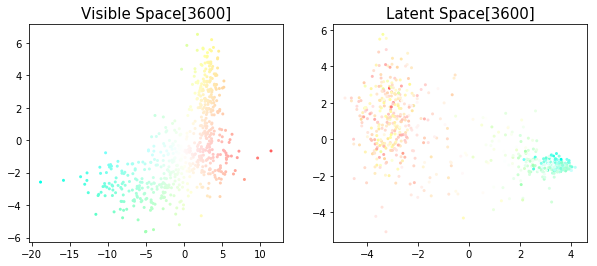

Save Model here..
Iter 3960: L_tot 1448.934 L_MSE 1442.806 L_divergence 6.128
Iter 4320: L_tot 1578.662 L_MSE 1571.887 L_divergence 6.774
Iter 4680: L_tot 1280.056 L_MSE 1274.042 L_divergence 6.014
Iter 5040: L_tot 1251.154 L_MSE 1244.724 L_divergence 6.429
Iter 5400: L_tot 1288.783 L_MSE 1282.939 L_divergence 5.845


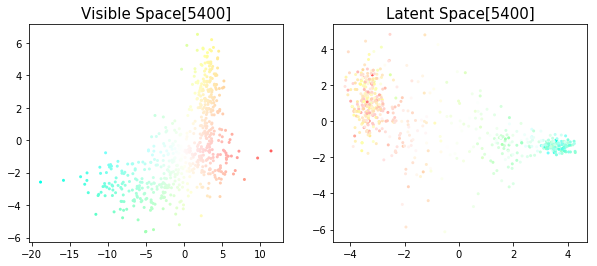

Iter 5760: L_tot 924.430 L_MSE 918.695 L_divergence 5.735
Iter 6120: L_tot 1017.980 L_MSE 1012.249 L_divergence 5.732
Iter 6480: L_tot 1029.535 L_MSE 1024.353 L_divergence 5.181
Iter 6840: L_tot 863.534 L_MSE 858.166 L_divergence 5.367
Iter 7200: L_tot 605.084 L_MSE 599.390 L_divergence 5.694


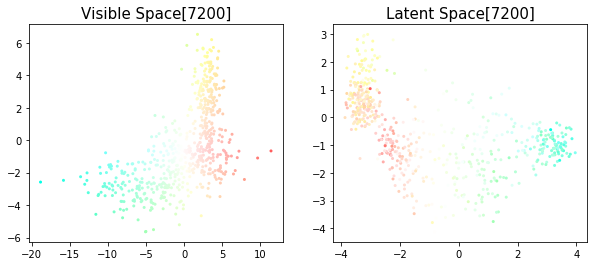

Save Model here..
Iter 7560: L_tot 740.021 L_MSE 734.139 L_divergence 5.882
Iter 7920: L_tot 812.748 L_MSE 806.731 L_divergence 6.017
Iter 8280: L_tot 831.365 L_MSE 825.346 L_divergence 6.019
Iter 8640: L_tot 844.479 L_MSE 838.592 L_divergence 5.887
Iter 9000: L_tot 792.016 L_MSE 785.511 L_divergence 6.505


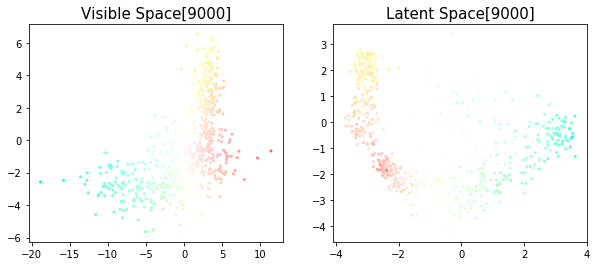

Iter 9360: L_tot 833.988 L_MSE 827.735 L_divergence 6.254
Iter 9720: L_tot 853.259 L_MSE 846.229 L_divergence 7.030
Iter 10080: L_tot 663.436 L_MSE 656.698 L_divergence 6.738
Iter 10440: L_tot 585.041 L_MSE 577.896 L_divergence 7.145
Iter 10800: L_tot 602.905 L_MSE 596.046 L_divergence 6.859


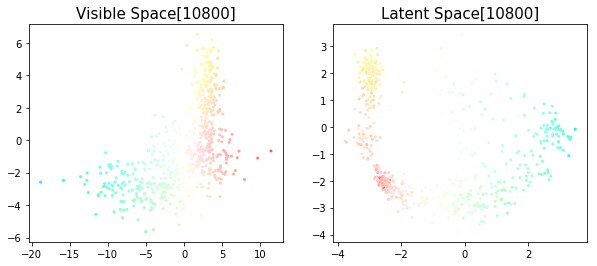

Save Model here..
Iter 11160: L_tot 543.781 L_MSE 536.798 L_divergence 6.983
Iter 11520: L_tot 791.395 L_MSE 784.779 L_divergence 6.616
Iter 11880: L_tot 574.886 L_MSE 567.919 L_divergence 6.967
Iter 12240: L_tot 594.978 L_MSE 587.562 L_divergence 7.416
Iter 12600: L_tot 434.524 L_MSE 427.211 L_divergence 7.313


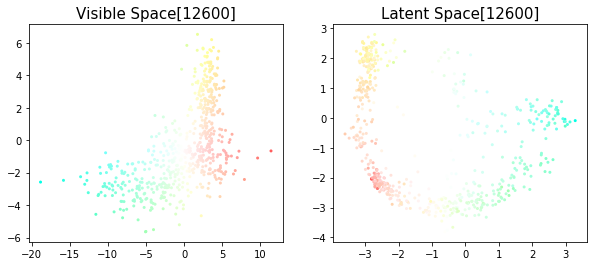

Iter 12960: L_tot 549.685 L_MSE 542.806 L_divergence 6.878
Iter 13320: L_tot 719.854 L_MSE 712.663 L_divergence 7.191
Iter 13680: L_tot 521.455 L_MSE 514.444 L_divergence 7.011
Iter 14040: L_tot 439.238 L_MSE 431.978 L_divergence 7.260
Iter 14400: L_tot 548.262 L_MSE 540.557 L_divergence 7.705


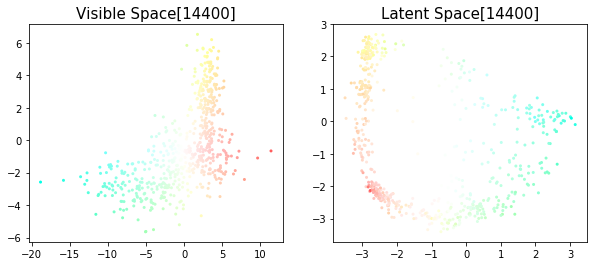

Save Model here..
Iter 14760: L_tot 447.533 L_MSE 440.015 L_divergence 7.518
Iter 15120: L_tot 412.850 L_MSE 405.374 L_divergence 7.476
Iter 15480: L_tot 409.026 L_MSE 401.822 L_divergence 7.204
Iter 15840: L_tot 442.321 L_MSE 434.728 L_divergence 7.593
Iter 16200: L_tot 377.249 L_MSE 369.318 L_divergence 7.931


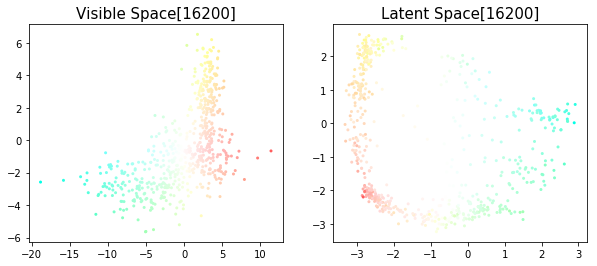

Iter 16560: L_tot 436.897 L_MSE 429.444 L_divergence 7.453
Iter 16920: L_tot 515.802 L_MSE 508.055 L_divergence 7.747
Iter 17280: L_tot 433.316 L_MSE 425.747 L_divergence 7.570
Iter 17640: L_tot 539.206 L_MSE 531.483 L_divergence 7.723
Iter 18000: L_tot 639.020 L_MSE 631.490 L_divergence 7.530


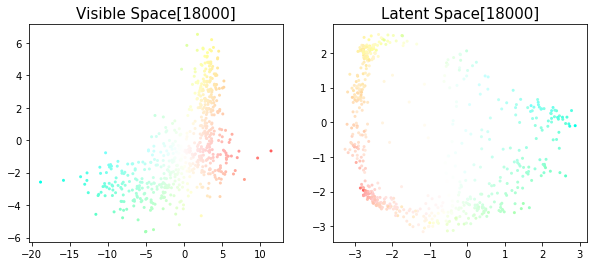

Save Model here..
Iter 18360: L_tot 416.590 L_MSE 408.774 L_divergence 7.816
Iter 18720: L_tot 461.782 L_MSE 453.727 L_divergence 8.054
Iter 19080: L_tot 395.178 L_MSE 387.391 L_divergence 7.787
Iter 19440: L_tot 575.178 L_MSE 567.306 L_divergence 7.872
Iter 19800: L_tot 467.504 L_MSE 459.898 L_divergence 7.606


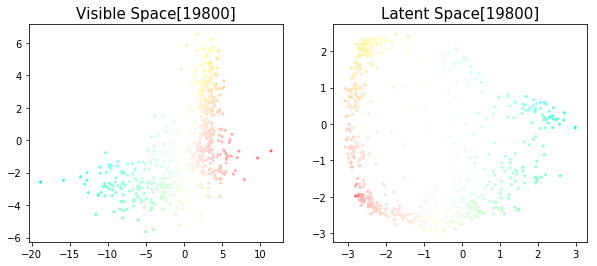

Iter 20160: L_tot 461.500 L_MSE 453.938 L_divergence 7.563
Iter 20520: L_tot 442.269 L_MSE 434.305 L_divergence 7.964
Iter 20880: L_tot 330.152 L_MSE 322.772 L_divergence 7.379
Iter 21240: L_tot 371.900 L_MSE 364.320 L_divergence 7.580
Iter 21600: L_tot 446.900 L_MSE 439.269 L_divergence 7.632


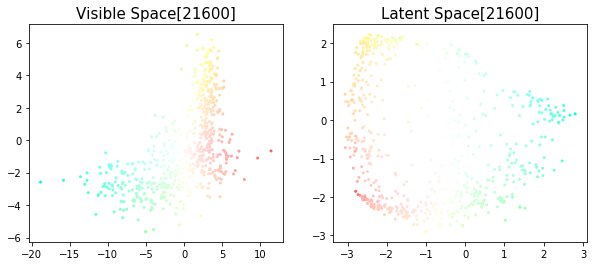

Save Model here..
Iter 21960: L_tot 391.711 L_MSE 384.097 L_divergence 7.614
Iter 22320: L_tot 471.701 L_MSE 464.201 L_divergence 7.500
Iter 22680: L_tot 433.928 L_MSE 426.653 L_divergence 7.275
Iter 23040: L_tot 384.260 L_MSE 376.962 L_divergence 7.298
Iter 23400: L_tot 420.280 L_MSE 412.667 L_divergence 7.612


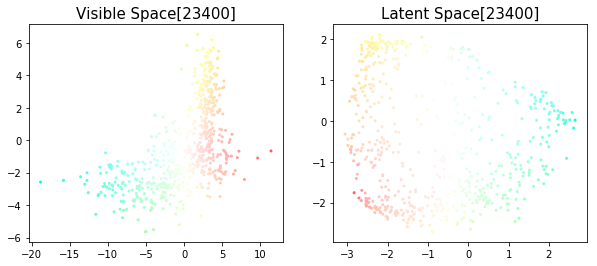

Iter 23760: L_tot 451.499 L_MSE 444.090 L_divergence 7.409
Iter 24120: L_tot 422.913 L_MSE 415.416 L_divergence 7.497
Iter 24480: L_tot 500.043 L_MSE 492.331 L_divergence 7.712
Iter 24840: L_tot 380.396 L_MSE 373.042 L_divergence 7.354
Iter 25200: L_tot 275.290 L_MSE 267.878 L_divergence 7.412


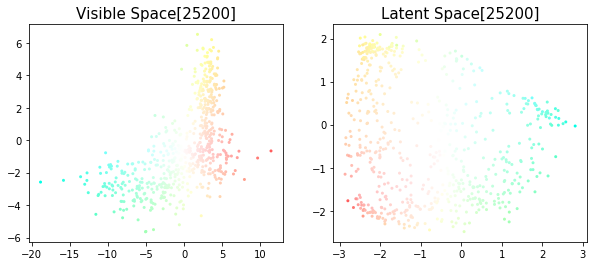

Save Model here..
Iter 25560: L_tot 318.980 L_MSE 312.058 L_divergence 6.922
Iter 25920: L_tot 454.192 L_MSE 446.780 L_divergence 7.411
Iter 26280: L_tot 263.740 L_MSE 256.223 L_divergence 7.517
Iter 26640: L_tot 464.647 L_MSE 457.384 L_divergence 7.263
Iter 27000: L_tot 378.910 L_MSE 371.415 L_divergence 7.495


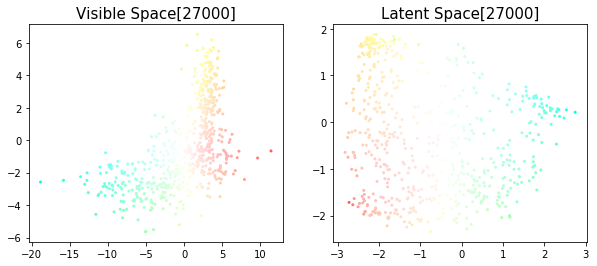

Iter 27360: L_tot 358.124 L_MSE 350.611 L_divergence 7.513
Iter 27720: L_tot 277.325 L_MSE 269.911 L_divergence 7.415
Iter 28080: L_tot 320.920 L_MSE 313.458 L_divergence 7.462
Iter 28440: L_tot 337.565 L_MSE 330.171 L_divergence 7.393
Iter 28800: L_tot 347.749 L_MSE 340.419 L_divergence 7.330


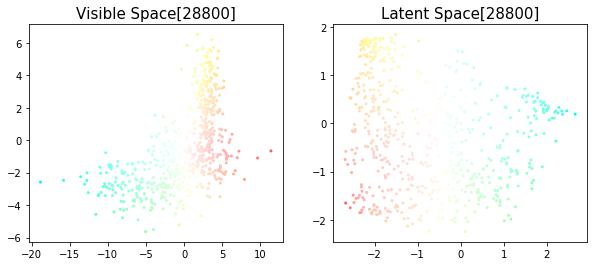

Save Model here..
Iter 29160: L_tot 301.124 L_MSE 293.724 L_divergence 7.399
Iter 29520: L_tot 292.870 L_MSE 285.542 L_divergence 7.328
Iter 29880: L_tot 330.994 L_MSE 323.487 L_divergence 7.507
Iter 30240: L_tot 316.528 L_MSE 309.158 L_divergence 7.370
Iter 30600: L_tot 267.253 L_MSE 259.537 L_divergence 7.716


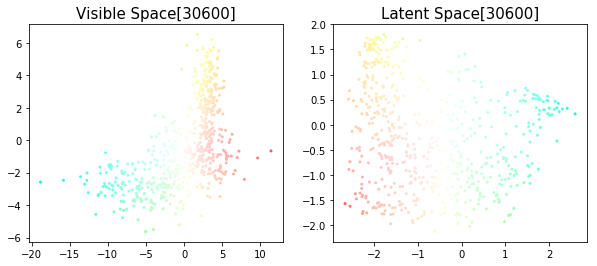

Iter 30960: L_tot 297.121 L_MSE 289.342 L_divergence 7.779
Iter 31320: L_tot 366.957 L_MSE 359.602 L_divergence 7.355
Iter 31680: L_tot 352.236 L_MSE 344.901 L_divergence 7.335
Iter 32040: L_tot 272.771 L_MSE 265.190 L_divergence 7.582
Iter 32400: L_tot 302.915 L_MSE 295.498 L_divergence 7.417


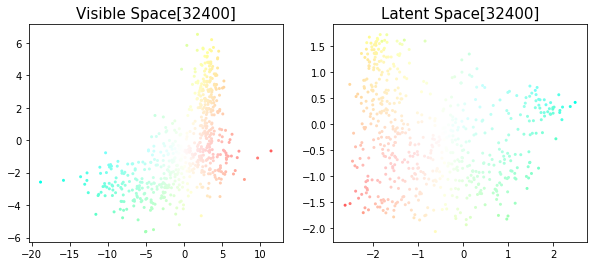

Save Model here..
Iter 32760: L_tot 348.333 L_MSE 340.790 L_divergence 7.543
Iter 33120: L_tot 333.941 L_MSE 326.614 L_divergence 7.327
Iter 33480: L_tot 479.472 L_MSE 472.057 L_divergence 7.415
Iter 33840: L_tot 377.369 L_MSE 369.868 L_divergence 7.501
Iter 34200: L_tot 328.170 L_MSE 320.671 L_divergence 7.499


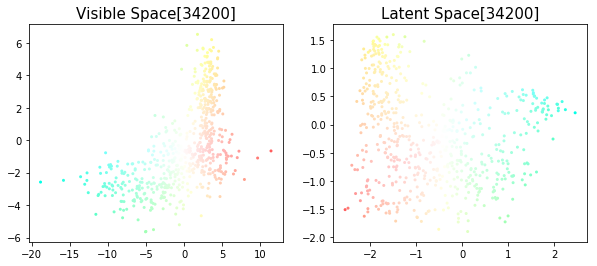

Iter 34560: L_tot 197.357 L_MSE 189.772 L_divergence 7.585
Iter 34920: L_tot 328.753 L_MSE 321.295 L_divergence 7.458
Iter 35280: L_tot 298.924 L_MSE 291.361 L_divergence 7.563
Iter 35640: L_tot 330.901 L_MSE 323.338 L_divergence 7.563


In [16]:
sess = tf.Session()
sess.run(tf.global_variables_initializer(), feed_dict={keep_prob : 0.9})

for iteration in range(n_iter):
    batch, cur_idx = next_batch(train_data, cur_idx, batch_size)
    batch_target = add_noise(batch)

    _, tot_loss, loss_mse, loss_divergence = sess.run(
        (train_op, loss, mse, KL_divergence),
        feed_dict={x_hat: batch, x: batch_target, keep_prob: 0.9}
    )

    if iteration % logs_step == 0:
        # Print Cost..
        print('Iter %d: L_tot %03.3f L_MSE %03.3f L_divergence %03.3f' % (iteration, tot_loss, loss_mse, loss_divergence))
    if iteration % draw_step == 0:
        latent = sess.run(z, feed_dict={x_hat:test_data, keep_prob: 1.0})
        scatter_2_data(test_data, latent, titles=["Visible Space[%d]" % iteration, "Latent Space[%d]" % iteration], c1=test_rgb_color, c2=test_rgb_color, figsize=(10, 4))
    if iteration % save_step == 0 and iteration > 0:
        # Save Model
        print("Save Model here..")

### Test

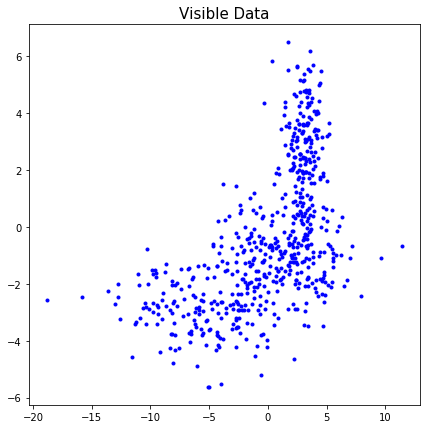

In [46]:
scatter_data(test_data[:,0], test_data[:,1], title="Visible Data", c='b', linewidths=1)

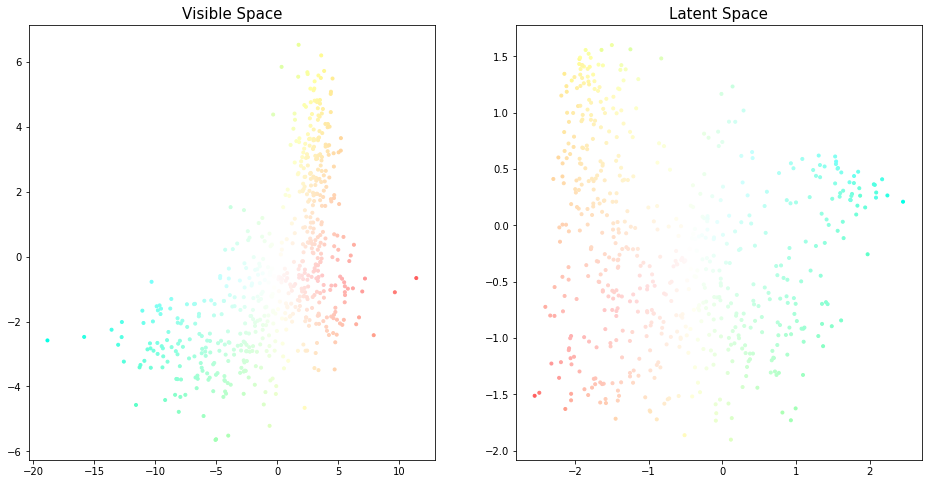

In [41]:
scatter_2_data(test_data, latent, titles=["Visible Space", "Latent Space"], c1=test_rgb_color, c2=test_rgb_color, linewidths=1, figsize=(16, 8))

In [20]:
generated_data.shape

(1, 2)

In [21]:
generated_data

array([[ 5.440579 , -1.6313483]], dtype=float32)

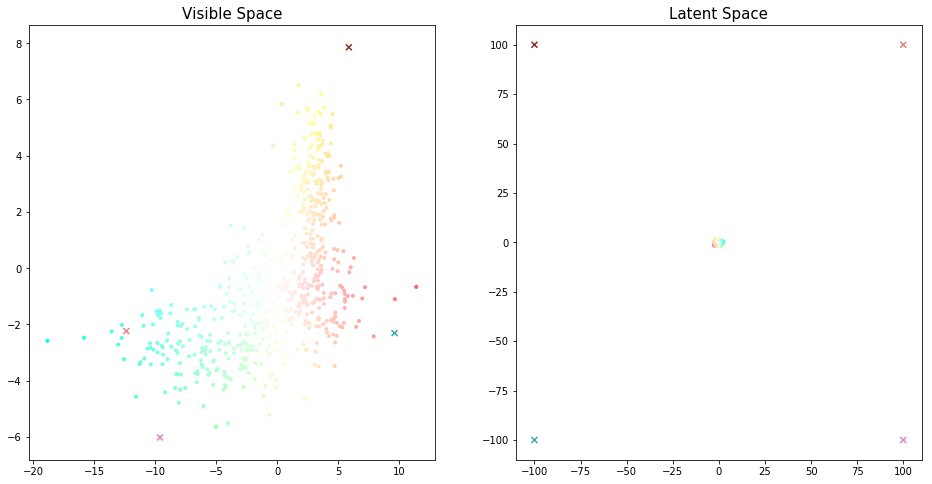

In [53]:
test_sample = np.array([[100, 100], [100, -100], [-100, -100], [-100, 100]])
generated_data = sess.run(decoded, feed_dict={z_in:test_sample, keep_prob:1.0})

scatter_2_data_test_sample(test_data, latent, generated_data, test_sample, linewidths=1, titles=["Visible Space", "Latent Space"], c1=test_rgb_color, c2=test_rgb_color, figsize=(16, 8))


In [ ]:
scatter_2_data_test_sample